# Prerequisites
In order to run the parser you need to install (pip or conda):
* Beautifulsoup4 (XML parser)
* lxml

In [1]:
from tools.ms3 import *
import scipy as sp
import matplotlib as plt
logging.getLogger().setLevel(logging.INFO)

# Configuration 

In [13]:
compute_all = False                              # Sets all 'compute_anew' flags to True
data ='data'                                     # data folders
data_ms3 = os.path.join(data,'MuseScore_3')
data_tsv = os.path.join(data,'tsv')
note_features = None                             # TODO: Pass selected features as kwargs to get_notes()
plt.rcParams['figure.figsize'] = [15,10]         # Change the plotsize for the entire notebook

# Loading the data
The dataframe `merged_ids` maps the 435 IDs to the files in the `data_ms3` folder. The different types of trios (trio I, trio II, alternative trio) are all replaced by the term 'trio'.

In [9]:
merged_ids = os.path.join(data_ms3, 'merged_ids.tsv')
files = pd.read_csv(merged_ids, sep='\t', index_col=0)
files.loc[files.dance.str.contains('trio'), 'dance'] = 'trio'
files.head()

,D,no,dance,path
id,,,,
1,41,1,menuett,041/D041menuett01a.mscx
2,41,1,trio,041/D041trio01b.mscx
3,41,2,menuett,041/D041menuett02a.mscx
4,41,2,trio,041/D041trio02b.mscx
5,41,3,menuett,041/D041menuett03a.mscx


#### Accessibility
We check whether all files are accessible.

In [10]:
missing = [file for file in files.path.values if not os.path.isfile(os.path.join(data_ms3, file))]
if missing != []:
    print("These files are missing:\n" + '\n'.join(missing))
else:
    print("All files found.")

All files found.


## Computing or loading the DataFrame representation of the music
We will be working on the data set in the form of note_lists. These can be newly computed from the scores or loaded from the precomputed TSV.

In [19]:
compute_anew = False

if compute_anew:
    
    def get_note_list(df):
        S = Score(os.path.join(data_ms3,df.iloc[0].path))
        return S.get_notes()
    
    note_list = files.groupby('id').apply(get_note_list)
    note_list.to_csv(os.path.join(data_tsv, 'note_list_complete.tsv'), sep='\t')
else:
    note_list = pd.read_csv(os.path.join(data_tsv, 'note_list_complete.tsv'), sep='\t', index_col=[0,1,2])
note_list.head()

mc  mn onset duration gracenote nominal_duration scalar  tied  \
id section ix                                                                  
1  0       0    0   0     0     3/16       NaN              1/8    3/2   NaN   
           1    0   0     0     3/16       NaN              1/8    3/2   NaN   
           2    0   0  3/16     1/16       NaN             1/16      1   NaN   
           3    0   0  3/16     1/16       NaN             1/16      1   NaN   
           4    1   1     0      1/4       NaN              1/4      1   NaN   

               tpc  midi  staff  voice  volta  
id section ix                                  
1  0       0     3    57      1      1    NaN  
           1    -1    65      1      1    NaN  
           2     3    57      1      1    NaN  
           3    -1    65      1      1    NaN  
           4    -1    41      2      1    NaN

# Basic statistics

### Pieces per dance type

The corpus contains 435 pieces. The different types are distributed as follows:
walzer       132
ländler       78
ecossaise     74
deutscher     71
trio          48
menuett       29
galopp         2
cotillon       1
Name: dance, dtype: int64


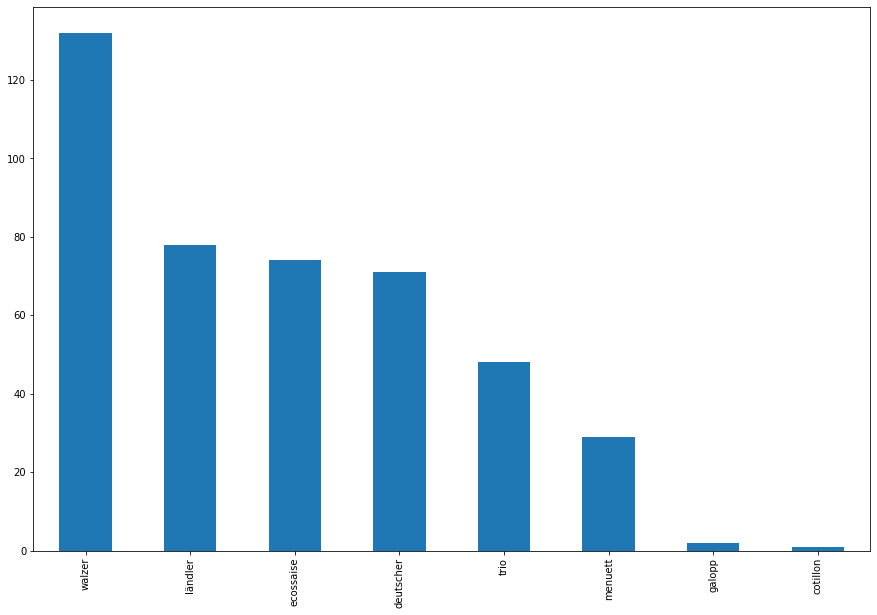

In [28]:
dance_types = files.dance.value_counts()
print(f"The corpus contains {len(files.index)} pieces. The different types are distributed as follows:{NL}{dance_types}")
dance_types.plot.bar();

### Number of notes

In [7]:
len(note_list.index)

101810

In [34]:
spell_tpc(note_list.tpc.unique())

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [29]:
PITCH_NAMES

{0: 'F', 1: 'C', 2: 'G', 3: 'D', 4: 'A', 5: 'E', 6: 'B'}

In [4]:
def notes_bag(n):
    """Returns the relative duration of each tonal pitch class in the nth dance"""
    
    note_bag = pd.DataFrame()
    for i in Score(DANCES.File[n]).section_order:
        note_bag = pd.concat([note_bag, Score(DANCES.File[n]).get_notes(pitch_names = True).loc[i]], ignore_index = True)
    
    notes = pd.DataFrame(columns = ['duration'], index = ['C', 'C#', 'C##', 'Dbb', 'Db', 'D', 'D#', 'D##','Ebb', 'Eb', 'E','E#','E##', 'Fbb', 'Fb','F', 'F#','F##','Gbb', 'Gb', 'G', 'G#','G##', 'Abb', 'Ab', 'A', 'A#', 'A##', 'Bbb', 'Bb', 'B', 'B#','B##', 'Cbb','Cb'])

    temp = pd.DataFrame(note_bag.groupby('pitch_names')['duration'].sum()/note_bag.duration.sum())
    
    for note in temp.index:
        notes.loc[note] = temp.loc[note]
    
    #notes.columns = ['tonal_duration']
    
    #return temp.index
    return notes.applymap(float)

In [76]:
temp = []
for dance in DANCES.index:
    if dance in failed_parse:
        temp += [np.nan]
    else:
        notes = notes_bag(dance)
        temp += [float(sp.stats.entropy(notes.dropna())/np.log(35))]
    
DANCES['entropy'] = temp

In [77]:
DANCES.head(10)

,File,Type,entropy
0,data/MuseScore_3/041/D041menuett01a.mscx,menuett,NaN
1,data/MuseScore_3/041/D041menuett02a.mscx,menuett,NaN
2,data/MuseScore_3/041/D041menuett03a.mscx,menuett,NaN
3,data/MuseScore_3/041/D041menuett04a.mscx,menuett,NaN
4,data/MuseScore_3/041/D041menuett05a.mscx,menuett,NaN
5,data/MuseScore_3/041/D041menuett06a.mscx,menuett,NaN
6,data/MuseScore_3/041/D041menuett07a.mscx,menuett,NaN
7,data/MuseScore_3/041/D041menuett08a.mscx,menuett,NaN
8,data/MuseScore_3/041/D041menuett09a.mscx,menuett,NaN
9,data/MuseScore_3/041/D041menuett10a.mscx,menuett,NaN


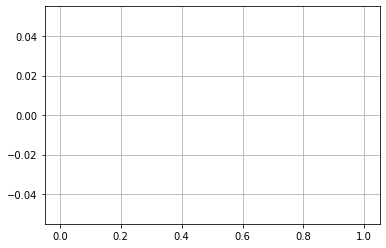

In [78]:
DANCES.entropy.hist();

In [79]:
DANCES.groupby('Type').entropy.mean()

Type
cotillon            NaN
deutscher           NaN
ecossaise           NaN
galopp              NaN
introduzione.mscx   NaN
ländler            NaN
menuett             NaN
trio                NaN
walzer              NaN
Name: entropy, dtype: float64

In [80]:
def keysig(n):
    return Score(DANCES.File[n]).mc_info[0].keysig[0]

In [81]:
temp = []
for i in DANCES.index:
    if i in failed_parse:
        temp += [np.nan]
    else:
        temp += [keysig(i)]

DANCES['Keysig'] = temp

In [82]:
sp.stats.pearsonr(DANCES.dropna().entropy, DANCES.dropna().Keysig )

NameError: name 'scipy' is not defined

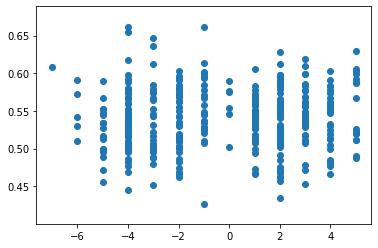

In [108]:
plt.scatter(DANCES.dropna().Keysig, DANCES.dropna().entropy);

In [ ]:
def KK(mode, transposition):
    """Krumhansl and Kessler (1982) key profiles for major and minor modes"""
    
    major = [6.20, 2.55, 3.45, 2.85, 4.22, 4.57, 2.67, 5.25, 2.45, 3.35, 2.70, 2.70]
    minor = [6.03, 3.35, 3.67, 5.28, 2.58, 3.55, 2.87, 4.80, 4.35, 2.67, 2.50, 3.42]
    
    #major = list(map(lambda x: x/sum(major), major))
    #minor = list(map(lambda x: x/sum(minor), minor))
    
    if mode == 0:
        return major[-transposition:]+major[:-transposition]
    elif mode == 1:
        return minor[-transposition:]+minor[:-transposition]
    else:
        print('0 = major, 1 = minor')